In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
%cd  /content/drive/'My Drive'

%pip install bdpy kornia timm tqdm



Mounted at /content/drive
/content/drive/My Drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 2.8 MB/s 
     |████████████████████████████████| 551 kB 28.7 MB/s 
     |████████████████████████████████| 549 kB 70.8 MB/s 
     |████████████████████████████████| 53 kB 1.9 MB/s 
     |████████████████████████████████| 182 kB 73.8 MB/s 


In [ ]:
import csv
import fnmatch
import glob
import os
from datetime import datetime

import PIL.Image
# import caffe
import lmdb
import numpy as np
import pandas as pd
# from PIL.Image import resize as imresize

import bdpy
import lmdb
import pickle
from torchvision.transforms import Resize
import torchvision.transforms.functional as TF
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms.functional import equalize,rgb_to_grayscale
from kornia.enhance import equalize_clahe
import kornia
import matplotlib.pyplot as plt
import timm
import tqdm
from tqdm.autonotebook import tqdm
import itertools
torch.set_default_dtype(torch.float64)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [ ]:
class ImageObject:
    def __init__(self, image):
        # Dimensions of image for reconstruction - not really necessary 
        # for this dataset, but some datasets may include images of 
        # varying sizes
        self.channels = image.shape[2]
        self.size = image.shape[:2]
        self.image = image.tobytes()

    def get_image(self):
        """ Returns the image as a numpy array. """
        image = np.frombuffer(self.image, dtype=np.uint8)
        return image.reshape(*self.size, self.channels)
    
    


def create_lmdb(image_dir = "", output_dir = "",image_file_pattern ='*.JPEG', img_size = 248):
    """ Stores images to a LMDB.
        Parameters:
        ---------------
        image       image array, (32, 32, 3) to be stored
        image_id    integer unique ID for image
    """
    if os.path.exists(output_dir):
        print('%s already exists. Skipped.' % output_dir)
    else:
        os.makedirs(output_dir)
        
    image_list = glob.glob(os.path.join(image_dir, image_file_pattern))
    map_size = map_size = 100 * 1024 * len(image_list) * 10 * 10

    # Create a new LMDB environment
    env = lmdb.open(output_dir, map_size=map_size)

    # Start a new write transaction
    with env.begin(write=True) as txn:
        count = 0
        for image_file in image_list:
            image_id = os.path.splitext(os.path.basename(image_file))[0]
            image = PIL.Image.open(image_file)
            image = np.array(image)
             # Monochrome --> RGB
            if image.ndim == 2:
                img_rgb = np.zeros((image.shape[0], image.shape[1], 3), dtype=image.dtype)
                img_rgb[:, :, 0] = image
                img_rgb[:, :, 1] = image
                img_rgb[:, :, 2] = image
                image = img_rgb

            img_obj = ImageObject(image)
            key = image_id
            txn.put(key.encode("ascii"), pickle.dumps(img_obj))
            count = count + 1
            if count %100 == 0:
                print(count)
    env.close()


In [ ]:
# Run once to setup lmdb database
# create_lmdb("data/images/training", "training1")
# create_lmdb("data/images/test", "test1")
#create_lmdb("ArtificialImage", "lmdb_artificial_images", image_file_pattern ='*.tiff')

In [ ]:
from torchvision.utils import ImageFont
import cv2

batch_size = 64
momentum = 0.9
lr = 0.01
epochs = 20
log_interval = 100

class ImageReconstructionDataset(Dataset):

    def __init__(self, X_paths=[], y_path= "",start=0,end=None):
        
    
        
        mris = []
        images = []
        self.env = lmdb.open(y_path)
            
        for path in X_paths:
            fmri_data_bd = bdpy.BData(path)
            # Get fMRI data in the ROI
            fmri_data = fmri_data_bd.select('ROI_VC = 1')

            # Normalize fMRI data
            fmri_data_mean = np.mean(fmri_data, axis=0)
            fmri_data_std = np.std(fmri_data, axis=0)

            fmri_data = (fmri_data - fmri_data_mean) / fmri_data_std
            # fmri_data = fmri_data
            mris.append(torch.from_numpy(fmri_data))

            try:
                fmri_labels = fmri_data_bd.get('Label')[:, 1].flatten()

                # Convet image labels in fMRI data from float to file name labes (str)
                fmri_labels = ['n%08d_%d' % (int(('%f' % a).split('.')[0]),
                                              int(('%f' % a).split('.')[1]))
                                for a in fmri_labels]
            except Exception as e:
                df = pd.read_csv('stimulus_perceptionArtificialImage.tsv',sep = '\t',header=None)
                fmri_labels = fmri_data_bd.get('Label')
                fmri_labels = [df.loc[df[1]==int(a)][0].item()for a in fmri_labels]




                # for label in fmri_labels[:6000]:
                #     image = (pickle.loads(txn.get(label.encode("ascii"))).get_image())
                #     image = torch.from_numpy(image)
                #     image = torch.permute(image, (2,0,1))
                #     images.append(image)

        
        
        self.X = torch.cat(mris)
        if not end:
          end = self.X.shape[0]
        self.X = self.X[start:end]
        self.image_labels = fmri_labels[start:end]
        print(len(self.image_labels))
        # self.y = torch.stack(images)
        self.transform = transforms.Compose([transforms.Resize(224),
                                             
                                transforms.Normalize(mean=[0.0, 0.0, 0.0], std=[1.0, 1.0, 1.0])
                                
                                ])
    
    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):

        image_label = self.image_labels[idx]
        with self.env.begin(write=True) as txn:
            image = pickle.loads(txn.get(image_label.encode())).get_image()
            # path = "data/images/training/" + image_label + ".JPG"
            # print(path)
            # image = cv2.imread("data/images/training/" + image_label + ".JPEG") 
            # if image == None:
                # cv2.imread("data/images/training/" + image_label + ".jpg")
            image = torch.from_numpy(image)
            image = torch.permute(image, (2,0,1))
            image = transforms.functional.convert_image_dtype(image,dtype=torch.float64)
            # image = image.type(torch.float64)
            image = self.transform(image)

        return self.X[idx], image, image_label



In [ ]:
train_h5_paths = [
    
                # 'sub-01_perceptionArtificialImage_original_VC.h5'

    'data/fmri/sub-01_perceptionNaturalImageTraining_original_VC.h5',
                 
                #  'data/fmri/sub-02_perceptionNaturalImageTraining_original_VC.h5',
                  
                  # 'data/fmri/sub-03_perceptionNaturalImageTraining_original_VC.h5',
                 ]

lmdb_training = "training1"

In [ ]:
test_h5_paths = ['sub-01_perceptionArtificialImage_original_VC.h5',
                 
                #  'data/fmri/sub-02_perceptionNaturalImageTraining_original_VC.h5',
                  
                  # 'data/fmri/sub-03_perceptionNaturalImageTraining_original_VC.h5',
                 ]

lmdb_test = "lmdb_artificial_images"

In [ ]:
train_dataset = ImageReconstructionDataset(X_paths= test_h5_paths, y_path= lmdb_test, start=0,end=700)

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, num_workers=10,shuffle=True)

700


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
test_dataset = ImageReconstructionDataset(X_paths= test_h5_paths, y_path= lmdb_test,start=700,end=None)

testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=1, num_workers=0, shuffle=True)

100


<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)
<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)
<ipython-input-4-e7c105fdff55>:8

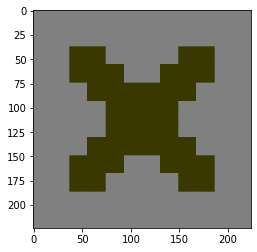

In [ ]:
for batch_idx, (mri, image,label) in enumerate(trainloader):
    import matplotlib.pyplot as plt
    # image = np.transpose(image,(1,2,0))
    # print(image)
    plt.imshow(image[0].squeeze().permute(1,2,0), interpolation='nearest')
    plt.show()
    break

In [ ]:
class CFG:
    debug = False
    batch_size = 32
    num_workers = 4
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 10
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

In [ ]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [ ]:
class MriEncoder(nn.Module):
    def __init__(self,encode_dim=256):
        super().__init__()
        
        self.fc = nn.Sequential(
                    nn.Linear(11726, 8192),
                    nn.BatchNorm1d(8192),
                    nn.ReLU(), 
                
                    nn.Linear(8192, 4096),
                    nn.BatchNorm1d(4096),
                    nn.ReLU(),
                    nn.Linear(4096, 2048),
                    nn.BatchNorm1d(2048),
                    nn.ReLU(),
                    nn.Linear(2048, 1024),
                    nn.BatchNorm1d(1024),
                    nn.ReLU(),
                    nn.Linear(1024, 512),
                    nn.BatchNorm1d(512),
                    nn.ReLU(),
                    nn.Linear(512, encode_dim),
                    nn.BatchNorm1d(256),
                    nn.Sigmoid(),                  
                    )
        

    def forward(self, input):
        input = self.fc(input)
        return input

In [ ]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, encode_dim = 256, model_name='resnet50', pretrained=True, trainable=True
    ):
        super().__init__()
        self.resnet = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.resnet.parameters():
            p.requires_grad = trainable


        self.fc1 = nn.Sequential(
                    nn.Linear(2048, 1024),
                    nn.BatchNorm1d(1024),
                    nn.ReLU())
        
        self.fc2 = nn.Sequential(
                    nn.Linear(1024, encode_dim),
                    nn.Sigmoid())


    def forward(self, x):
        # x = x.type(torch.float64).to(device)
        x = self.resnet(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [ ]:
class ImageDecoder(nn.Module):
    """
    Reconstrcut images from embeddings
    """

    def __init__(
        self, encode_dim = 256, model_name='resnet50', pretrained=True, trainable=True
    ):
        super().__init__()
        

        self.fc1 = nn.Sequential(
                    nn.Linear(encode_dim, 1024),
                    nn.BatchNorm1d(1024),
                    nn.ReLU())
        

        self.fc2 = nn.Sequential(
                    nn.Linear(1024, 64 * 4 * 4),
                    nn.BatchNorm1d(64*4*4),
                    nn.ReLU())
        
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2,
                               padding=0),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, kernel_size=3, stride=2,
                               padding=0),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),
        )

        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, kernel_size=3, stride=2,
                               padding=0),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()   
        )
        


    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x).view(-1, 64, 4, 4)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear')
        return x

In [ ]:
img_encoder = ImageEncoder().to(device)
img_decoder = ImageDecoder().to(device)
mri_encoder = MriEncoder().to(device)

img_encoder.load_state_dict(torch.load("best-img-encoder-shapes.pt", map_location=CFG.device))
img_decoder.load_state_dict(torch.load("best-img-decoder-shapes.pt", map_location=CFG.device))
mri_encoder.load_state_dict(torch.load("best-mri-encoder-shapes.pt", map_location=CFG.device))


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-rsb-weights/resnet50_a1_0-14fe96d1.pth" to /root/.cache/torch/hub/checkpoints/resnet50_a1_0-14fe96d1.pth


<All keys matched successfully>

In [ ]:
params = [
    {"params": img_encoder.parameters(), "lr": CFG.image_encoder_lr*100},
    {"params": img_decoder.parameters(), "lr": CFG.image_encoder_lr*100}
]
optimizer = torch.optim.AdamW(params, weight_decay=0.)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
)
step = "epoch"
criterion = nn.MSELoss()
best_loss = float('inf')

In [ ]:
for epoch in range(CFG.epochs):
    print(f"Epoch: {epoch + 1}")
    img_encoder.train()
    img_decoder.train()
    loss_meter = AvgMeter()
    tqdm_object = tqdm(trainloader, total=len(trainloader))
    for mris,images,labels in tqdm_object:
        mris,images = mris.to(device),images.to(device)
        embeddings = img_encoder(images)
        recon_imgs = img_decoder(embeddings)
        optimizer.zero_grad()
        loss = F.binary_cross_entropy(recon_imgs,images)
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = images.shape[0]
        loss_meter.update(loss.item(), count)
        tqdm_object.set_postfix(train_loss=loss_meter.avg)

    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(img_encoder.state_dict(), "best-img-encoder-shapes.pt")
        torch.save(img_decoder.state_dict(), "best-img-decoder-shapes.pt")

        print("Saved Best Model!")

    


In [ ]:
# mri_encoder = MriEncoder().to(device)
params = [
    {"params": mri_encoder.parameters(), "lr": 0.1},
    {"params": img_decoder.parameters(), "lr": 0.1}

]
optimizer = torch.optim.AdamW(params, weight_decay=0.)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
)
step = "epoch"
criterion = nn.MSELoss()
best_loss = float('inf')

In [ ]:
epochs = 100
for epoch in range(CFG.epochs):
    print(f"Epoch: {epoch + 1}")
    mri_encoder.train()
    img_encoder.eval()
    img_decoder.train()
    loss_meter = AvgMeter()
    tqdm_object = tqdm(trainloader, total=len(trainloader))
    for mris,images,labels in tqdm_object:
        mris,images = mris.to(device),images.to(device)
        embeddings = img_encoder(images)
        mri_embeddings = mri_encoder(mris)
        recon_imgs_mris = img_decoder(mri_embeddings)

        optimizer.zero_grad()
        loss1 = F.binary_cross_entropy(mri_embeddings,embeddings)
        loss2 = F.binary_cross_entropy(recon_imgs_mris,images)
        loss = loss1 + loss2
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = images.shape[0]
        loss_meter.update(loss.item(), count)
        tqdm_object.set_postfix(train_loss=loss_meter.avg)

    if loss.item() < best_loss:
        best_loss = loss.item()
        torch.save(mri_encoder.state_dict(), "best-mri-encoder-img-decoder-shapes.pt")
        torch.save(img_decoder.state_dict(), "best-img-decoder-mri-encoder-shapes.pt")

        print("Saved Best Model!")

Epoch: 1


  0%|          | 0/22 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)
<ipython-input-4-e7c105fdff55>:82: UserWa

Saved Best Model!
Epoch: 2


  0%|          | 0/22 [00:00<?, ?it/s]

<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)
<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)
<ipython-input-4-e7c105fdff55>:8

Epoch: 3


  0%|          | 0/22 [00:00<?, ?it/s]

<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)
<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)
<ipython-input-4-e7c105fdff55>:8

Epoch: 4


  0%|          | 0/22 [00:00<?, ?it/s]

<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)
<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)
<ipython-input-4-e7c105fdff55>:8

Epoch: 5


  0%|          | 0/22 [00:00<?, ?it/s]

<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)
<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)
<ipython-input-4-e7c105fdff55>:8

Epoch: 6


  0%|          | 0/22 [00:00<?, ?it/s]

<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)
<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)
<ipython-input-4-e7c105fdff55>:8

Saved Best Model!
Epoch: 7


  0%|          | 0/22 [00:00<?, ?it/s]

<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)
<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)
<ipython-input-4-e7c105fdff55>:8

Epoch: 8


  0%|          | 0/22 [00:00<?, ?it/s]

<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)
<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)
<ipython-input-4-e7c105fdff55>:8

Saved Best Model!
Epoch: 9


  0%|          | 0/22 [00:00<?, ?it/s]

<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)
<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)
<ipython-input-4-e7c105fdff55>:8

Epoch: 10


  0%|          | 0/22 [00:00<?, ?it/s]

<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)
<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)
<ipython-input-4-e7c105fdff55>:8

Saved Best Model!


  0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-4-e7c105fdff55>:82: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  image = torch.from_numpy(image)


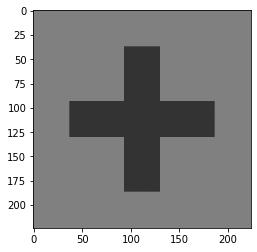

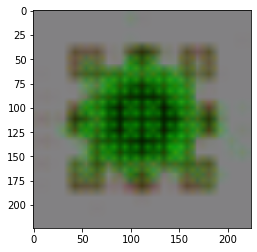

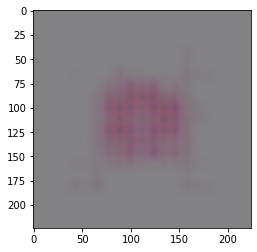

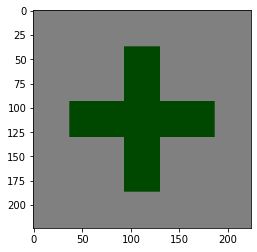

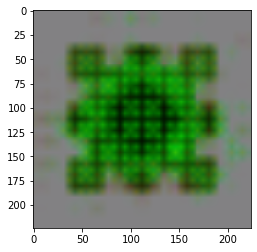

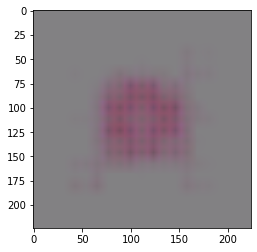

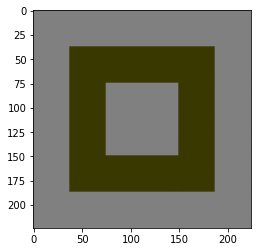

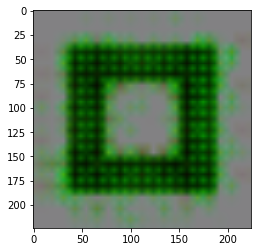

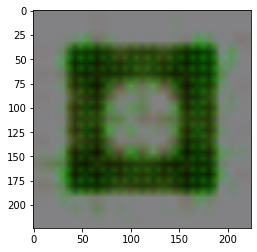

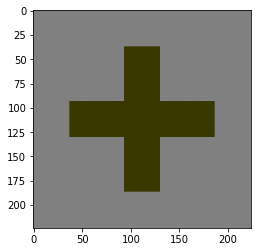

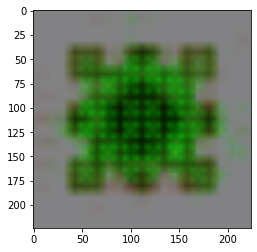

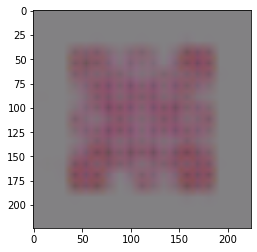

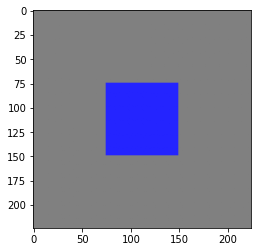

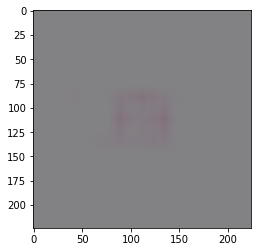

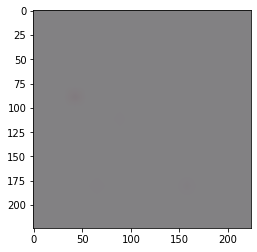

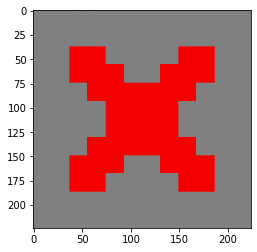

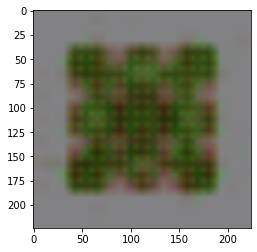

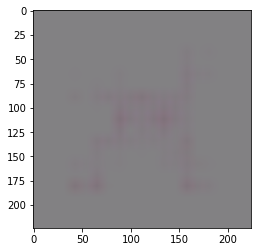

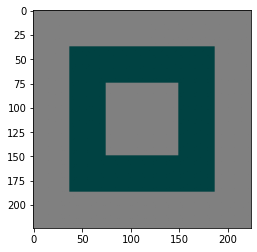

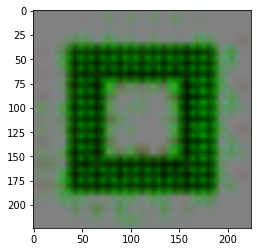

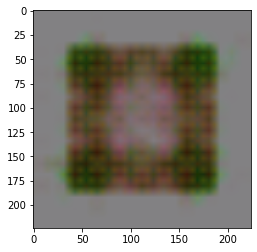

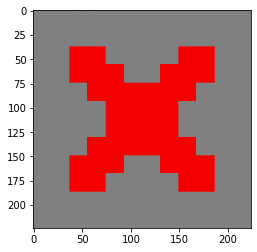

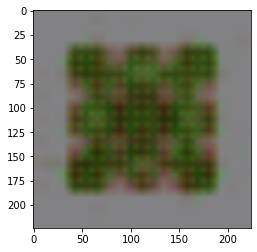

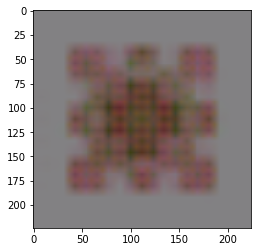

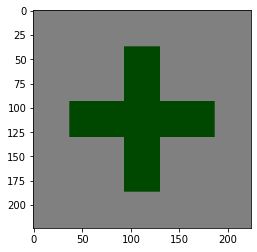

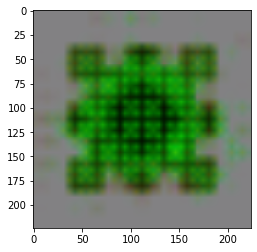

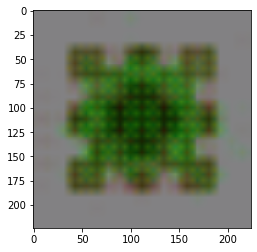

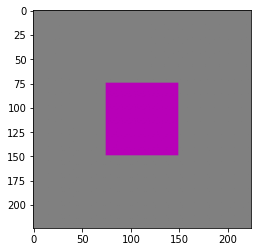

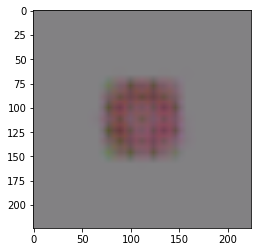

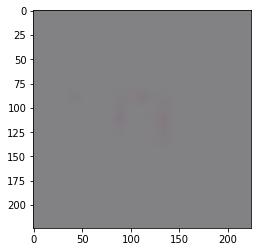

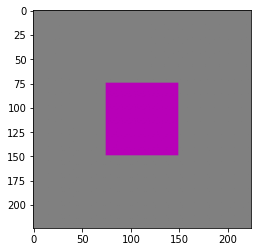

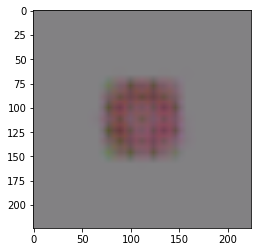

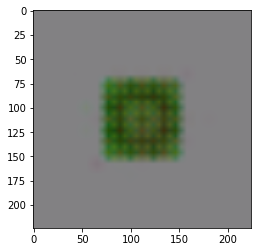

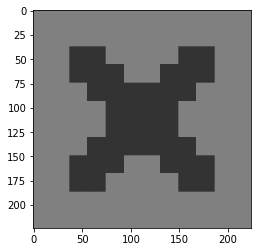

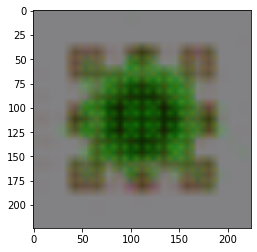

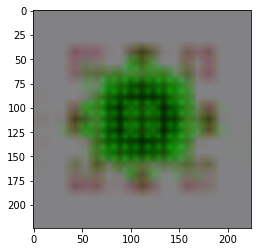

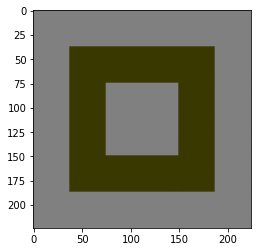

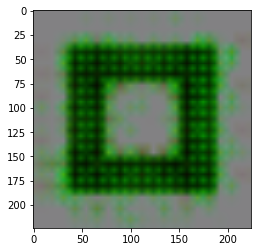

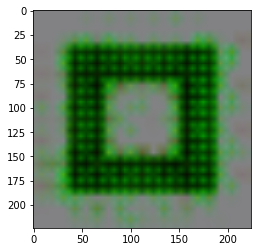

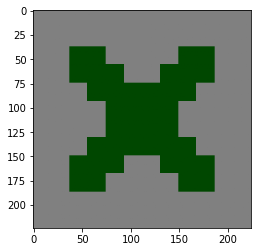

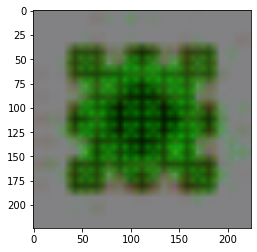

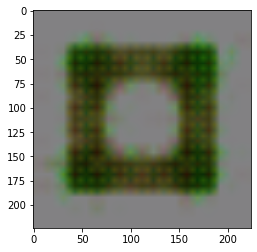

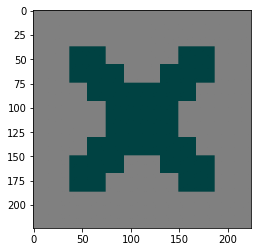

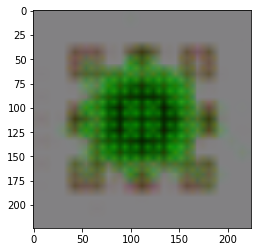

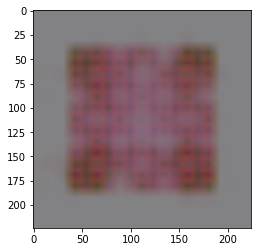

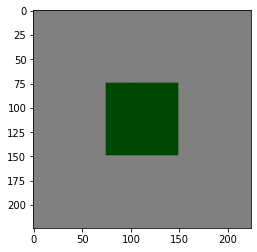

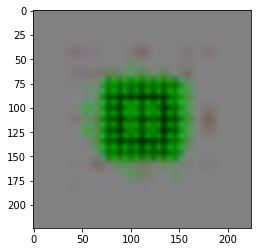

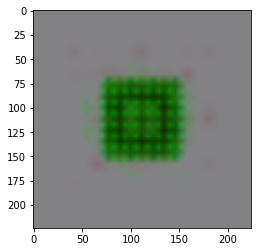

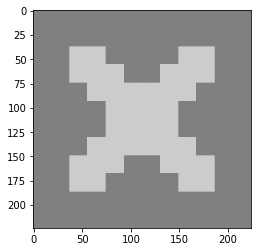

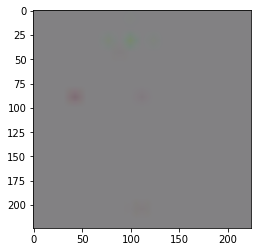

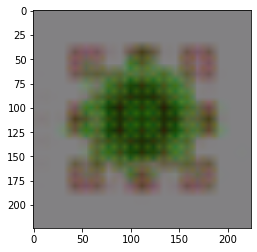

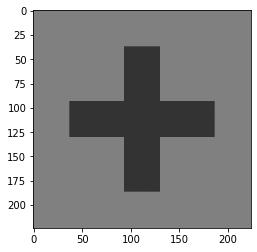

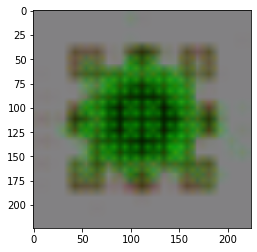

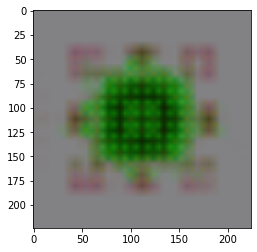

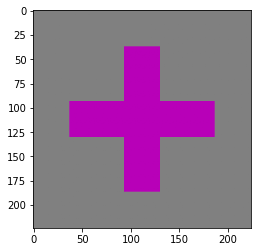

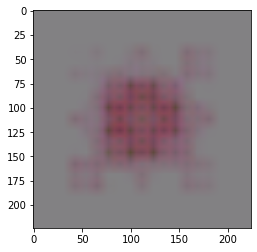

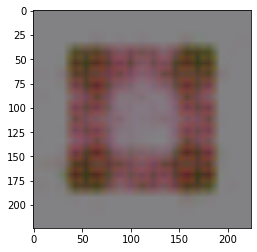

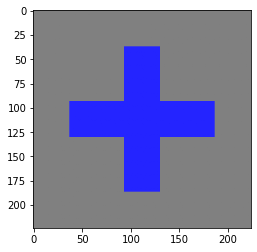

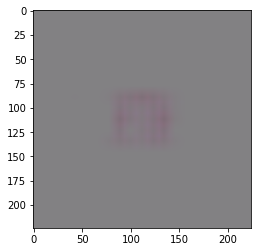

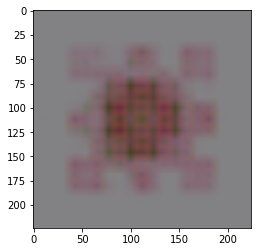

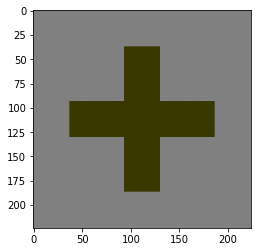

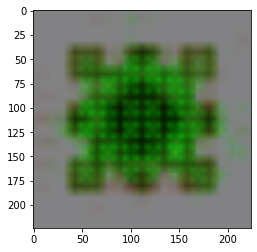

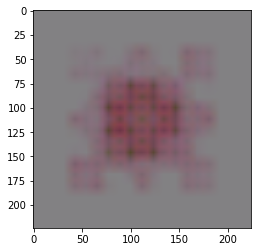

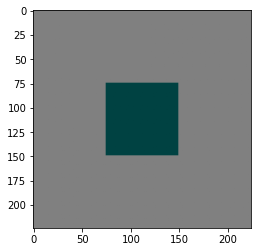

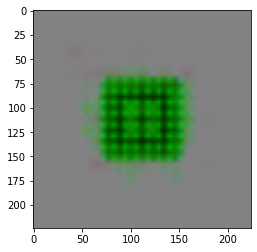

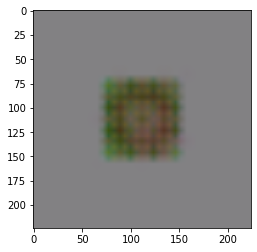

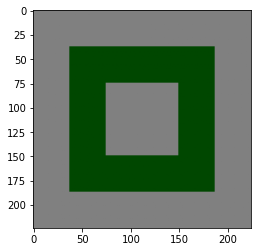

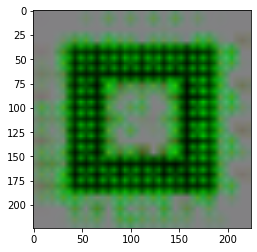

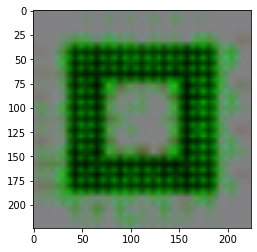

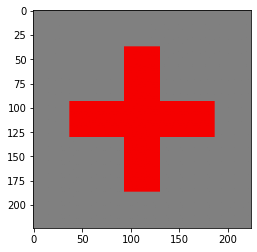

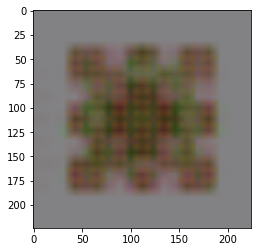

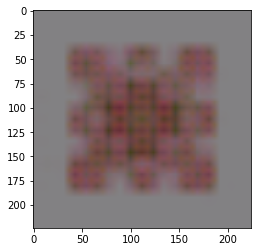

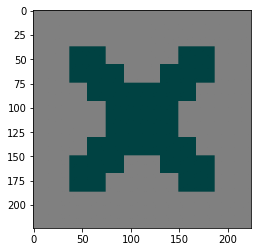

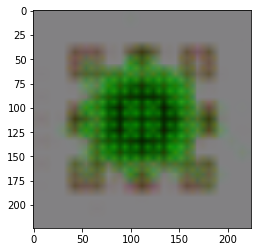

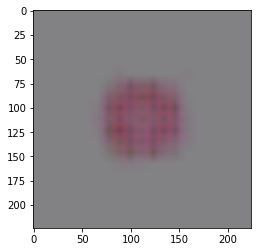

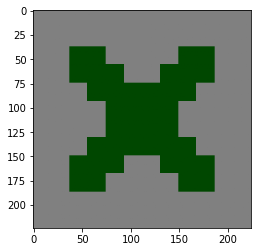

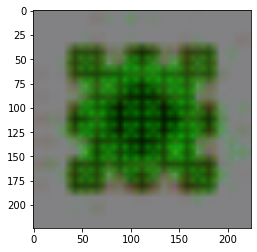

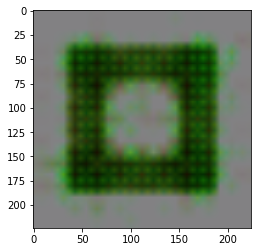

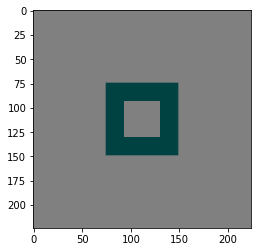

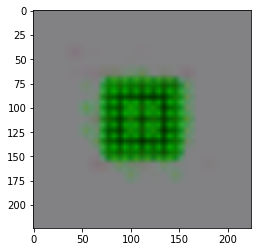

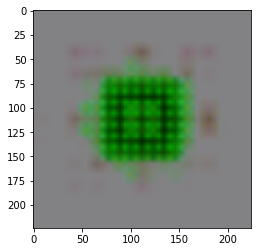

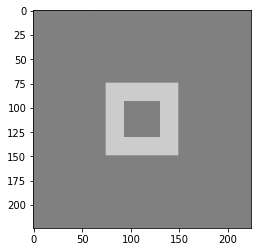

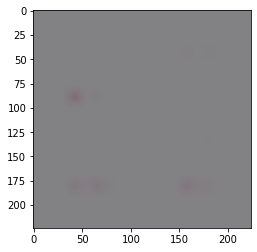

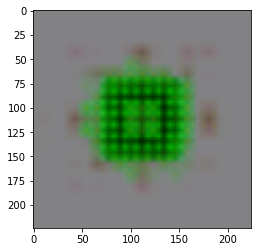

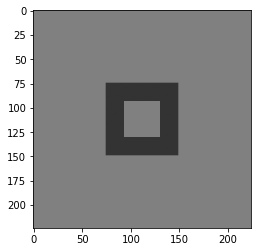

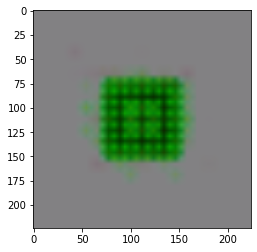

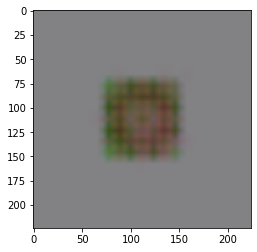

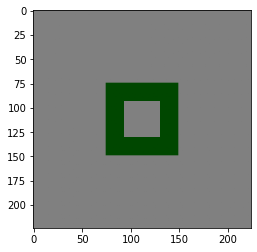

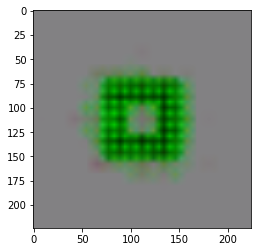

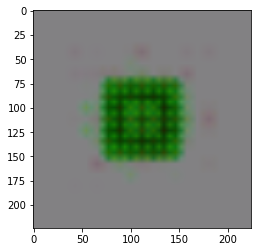

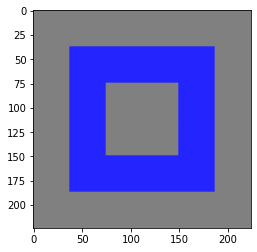

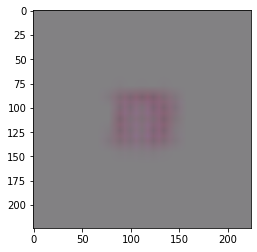

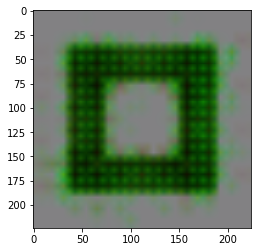

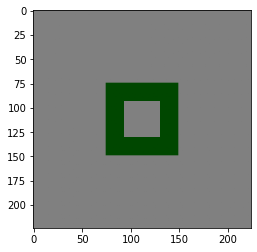

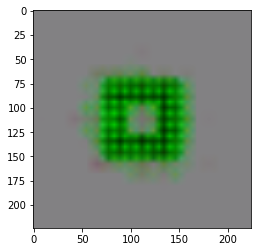

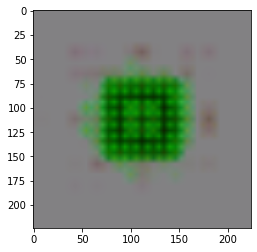

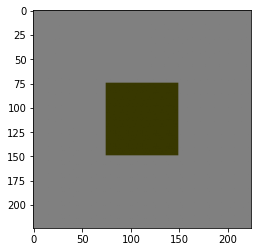

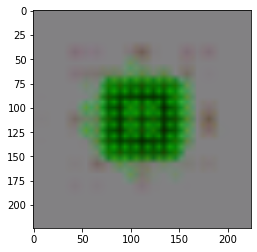

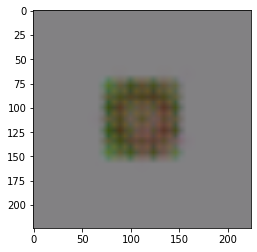

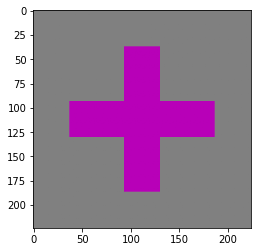

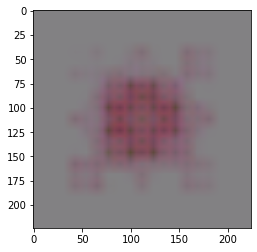

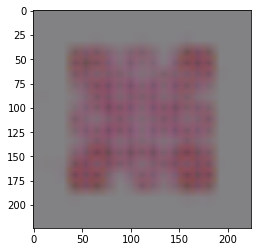

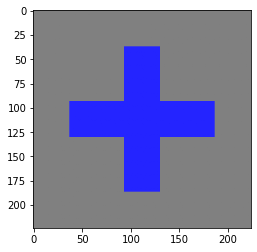

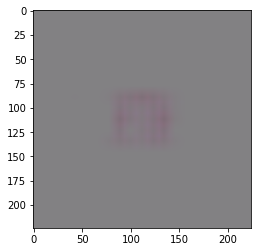

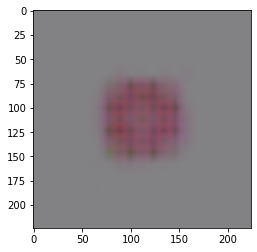

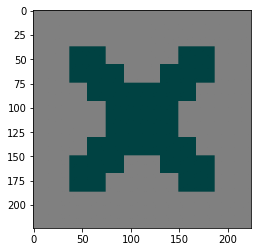

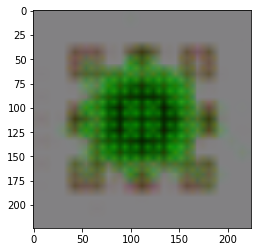

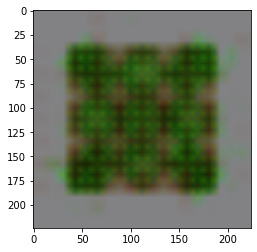

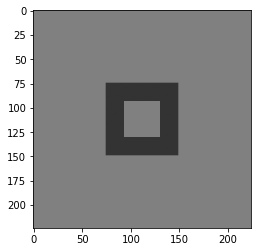

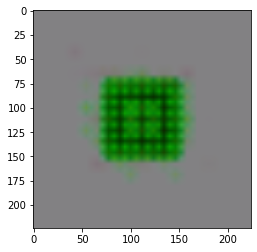

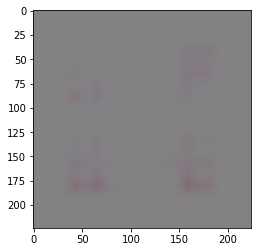

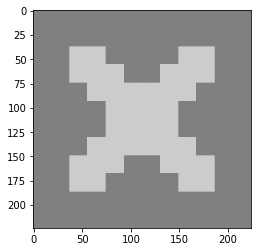

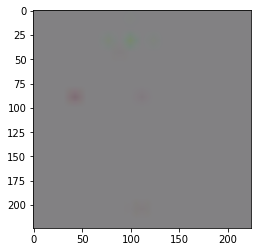

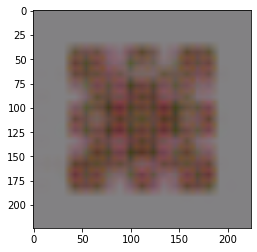

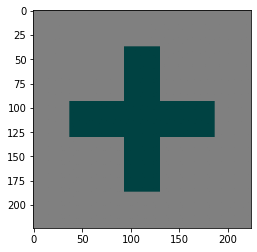

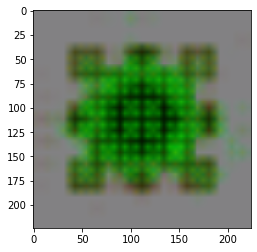

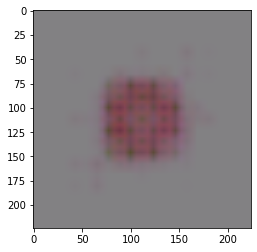

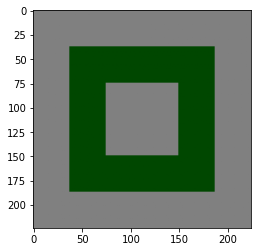

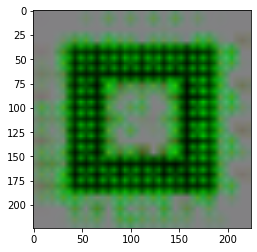

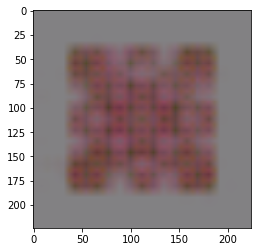

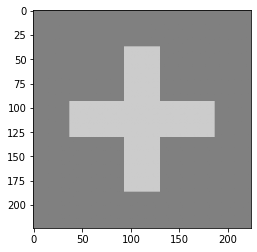

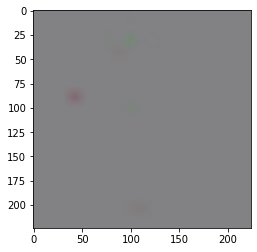

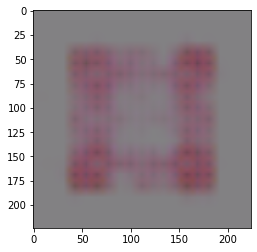

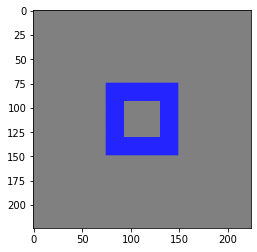

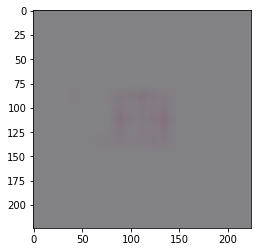

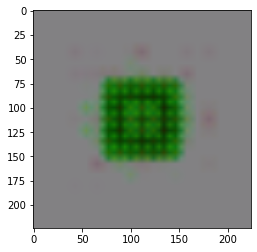

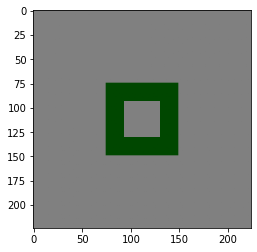

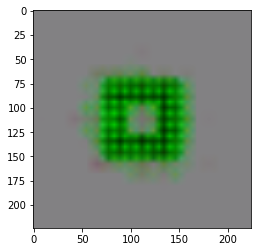

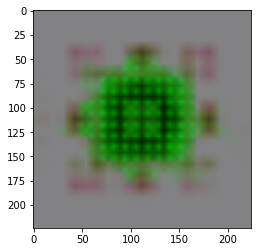

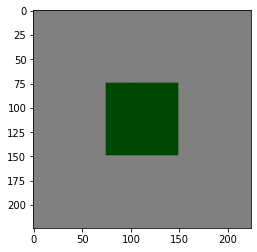

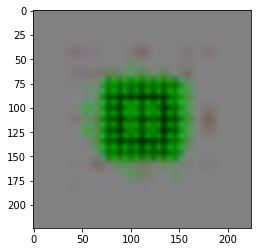

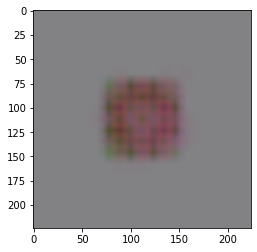

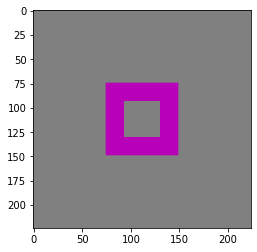

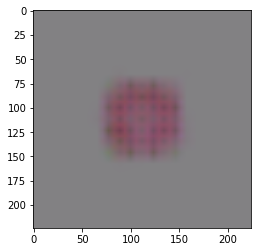

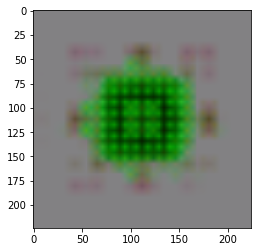

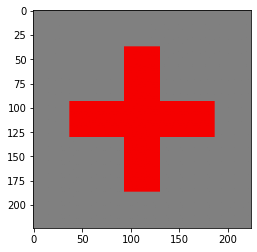

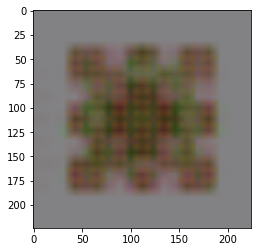

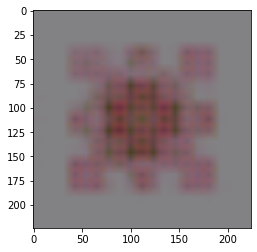

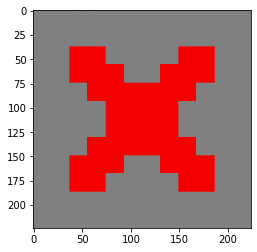

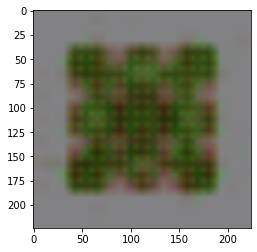

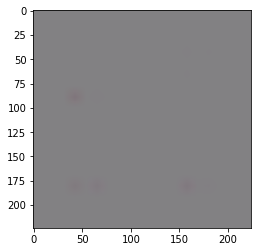

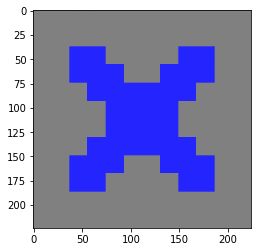

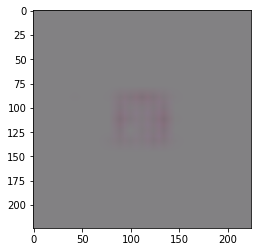

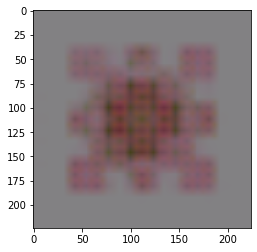

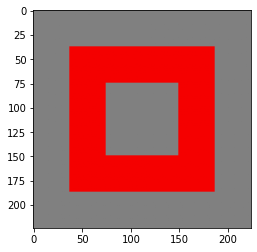

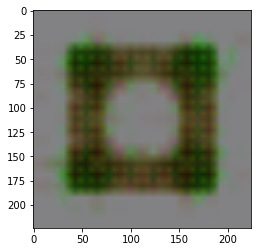

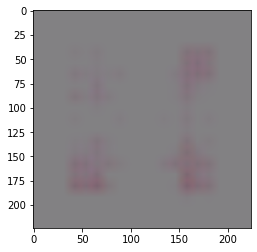

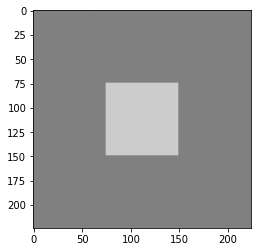

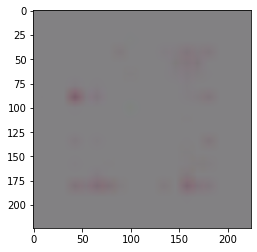

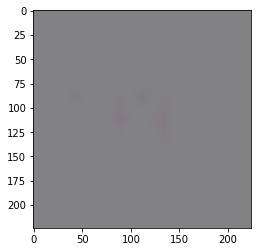

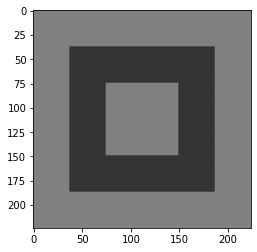

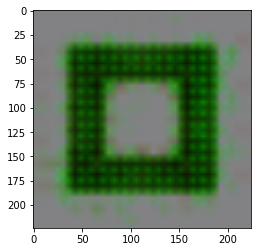

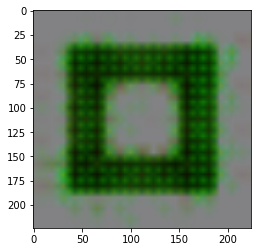

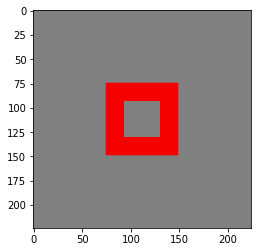

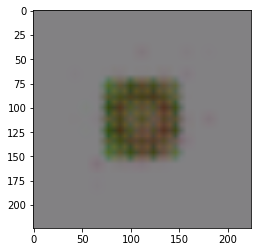

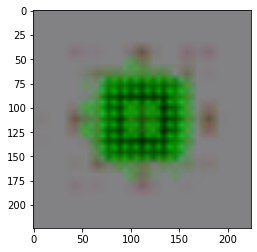

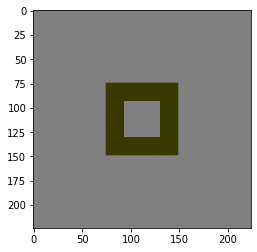

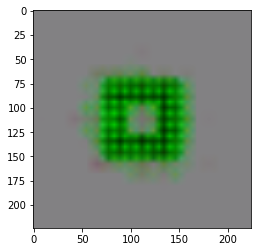

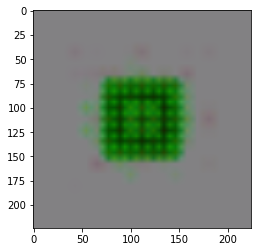

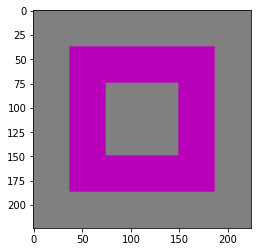

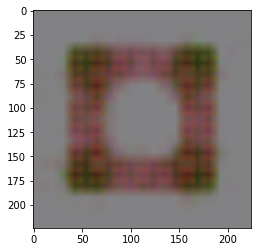

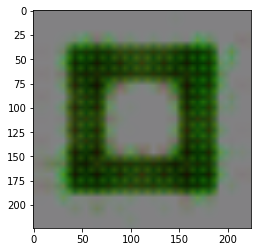

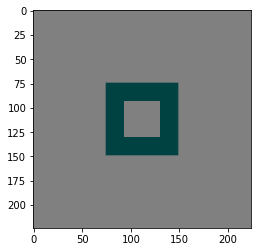

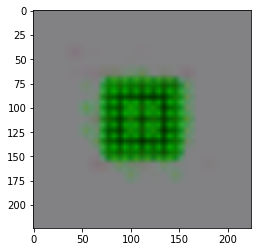

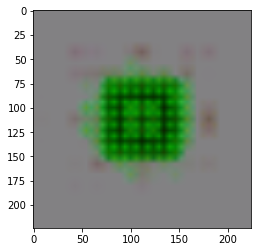

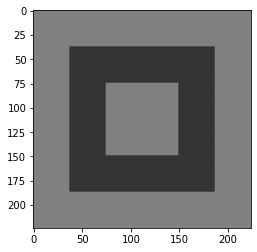

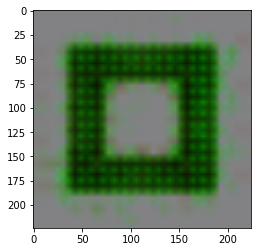

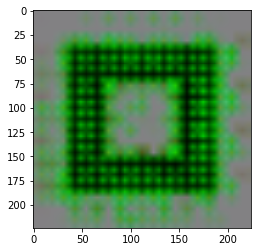

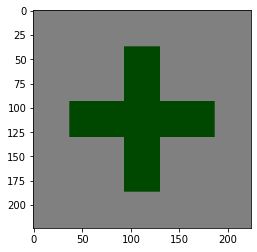

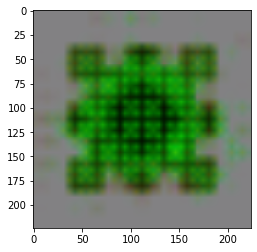

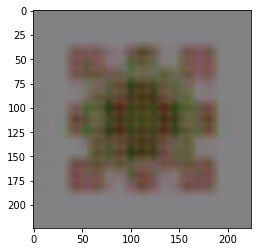

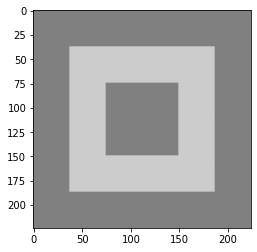

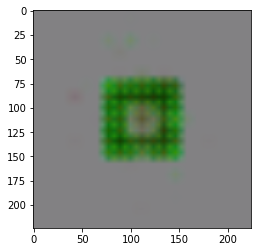

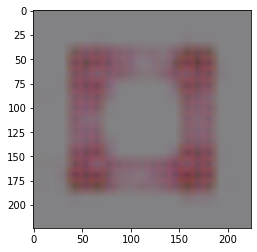

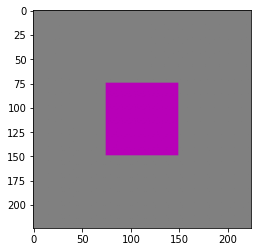

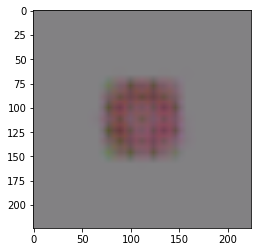

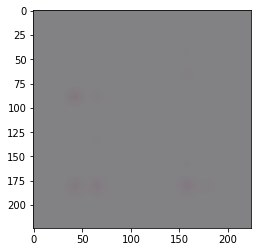

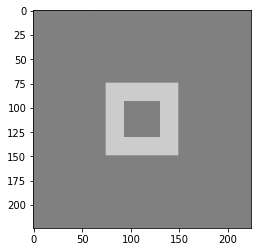

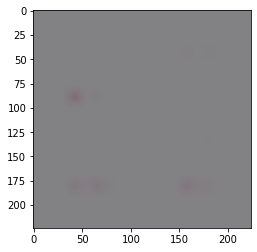

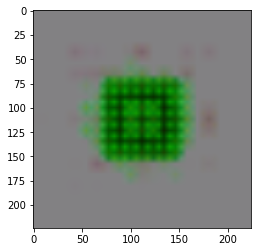

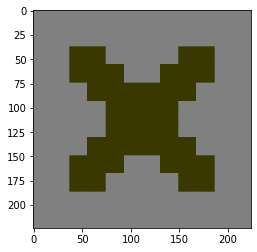

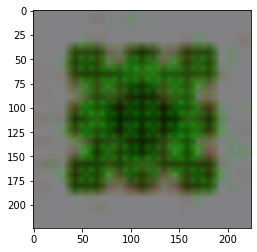

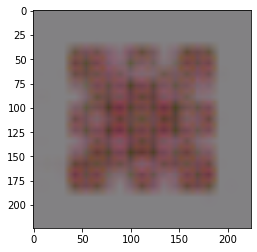

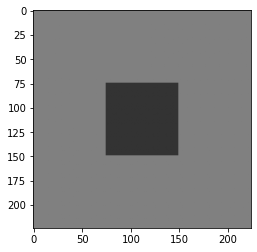

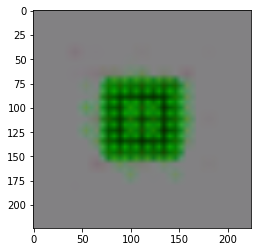

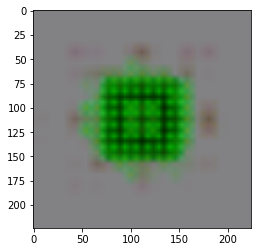

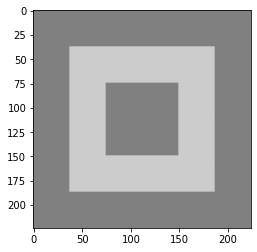

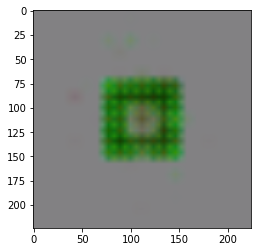

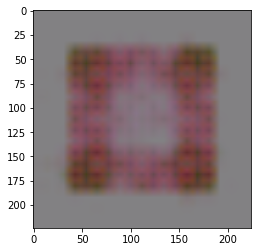

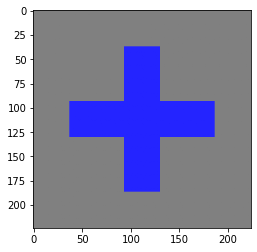

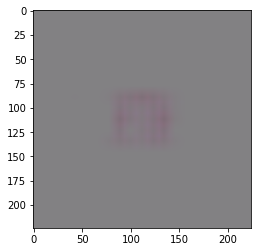

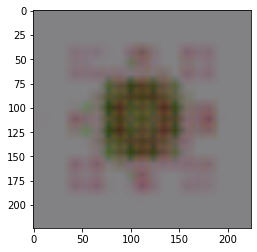

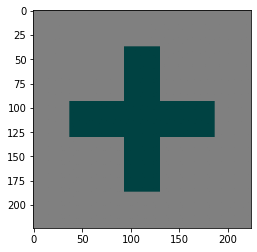

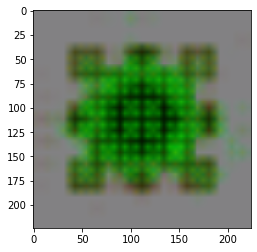

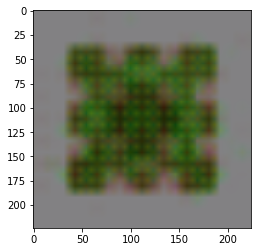

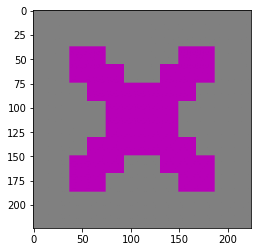

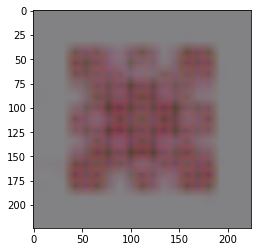

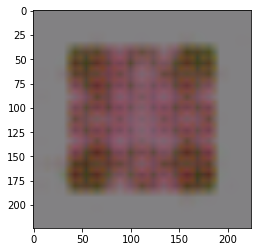

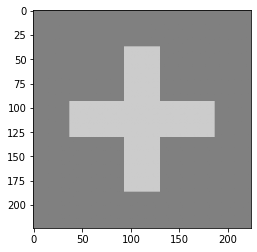

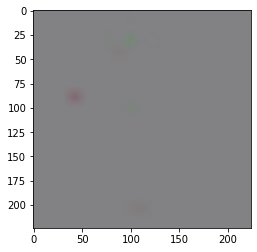

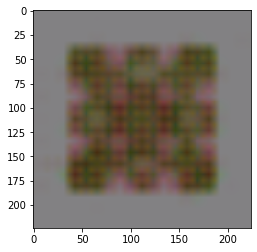

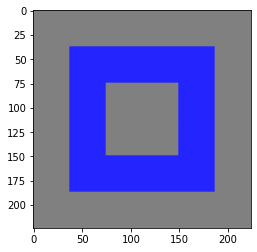

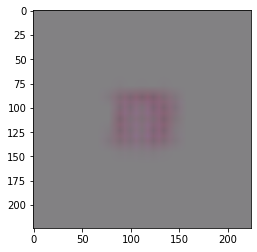

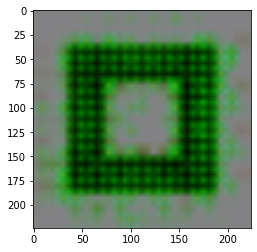

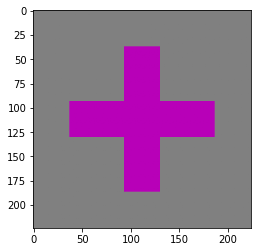

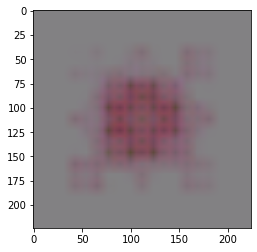

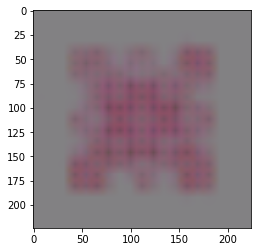

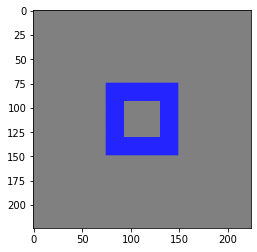

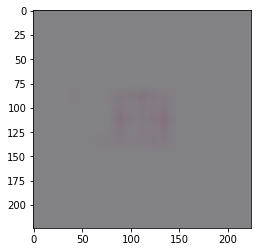

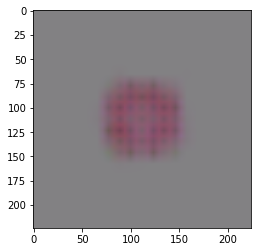

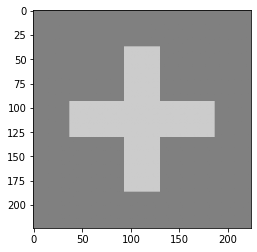

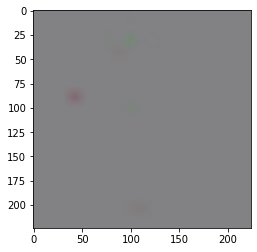

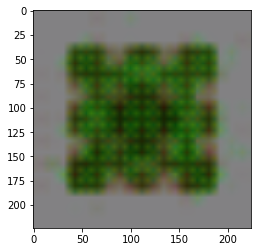

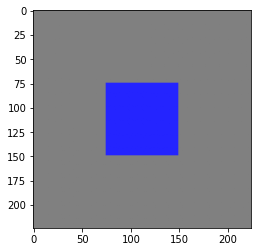

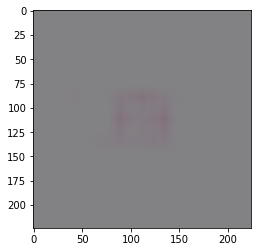

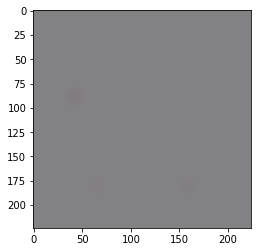

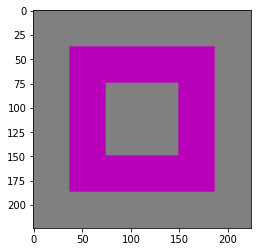

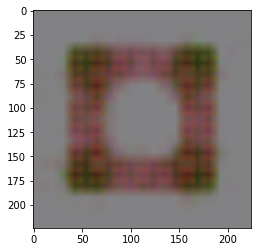

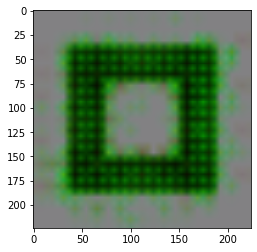

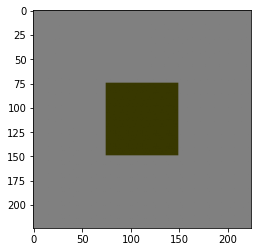

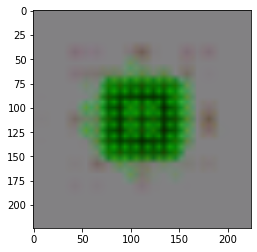

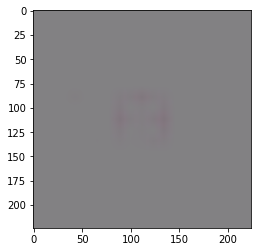

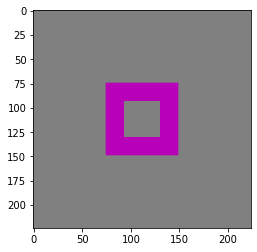

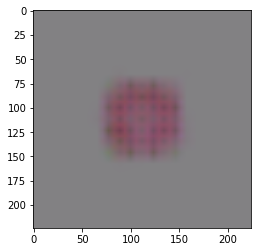

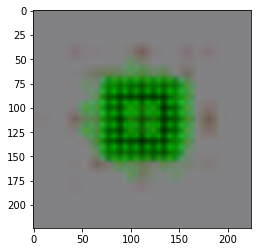

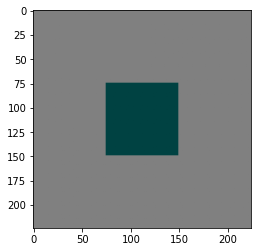

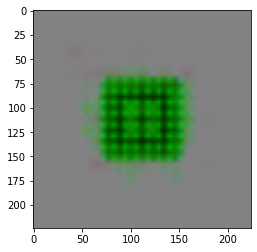

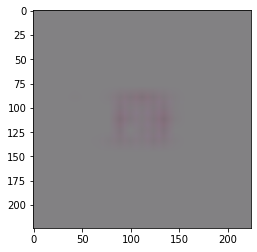

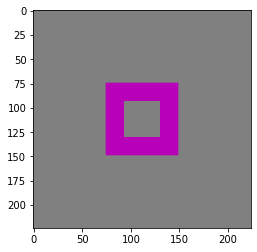

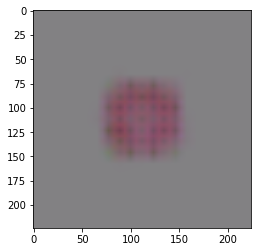

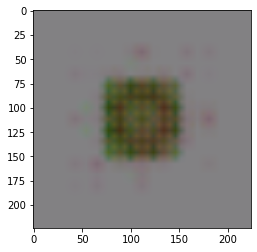

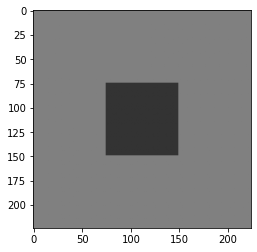

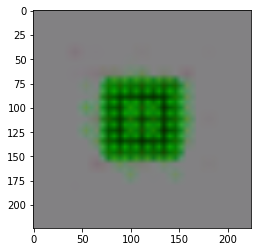

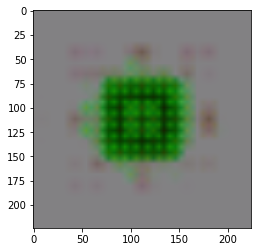

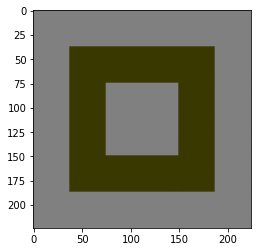

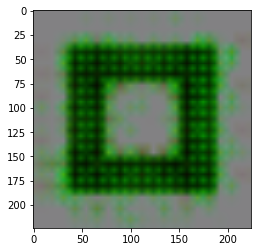

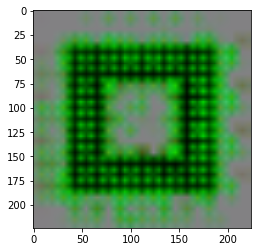

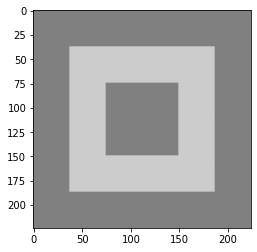

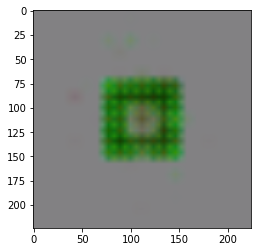

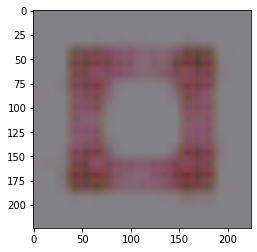

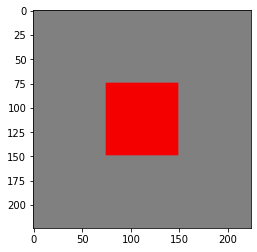

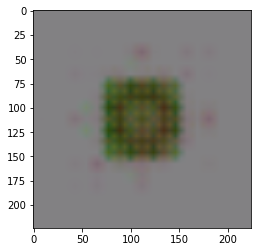

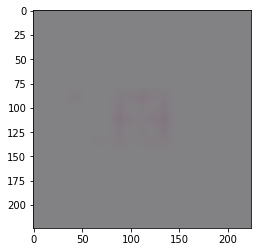

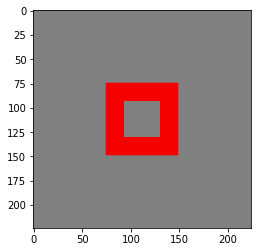

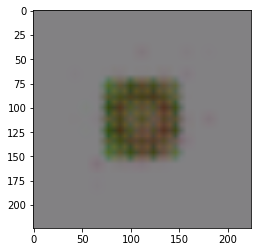

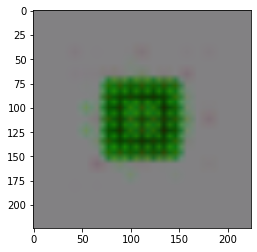

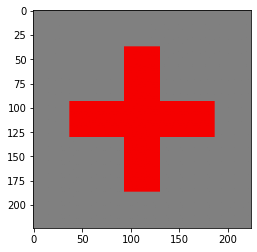

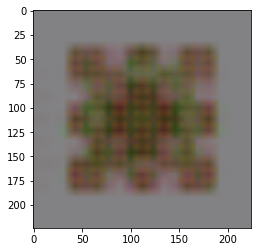

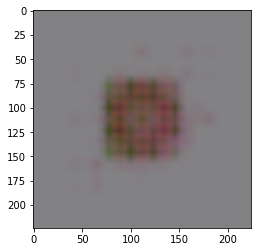

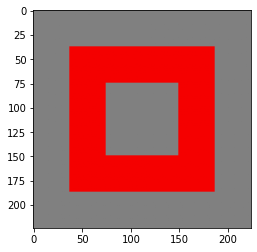

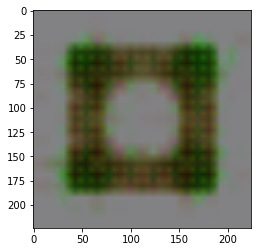

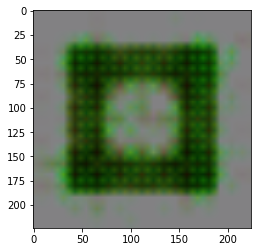

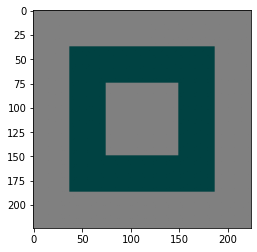

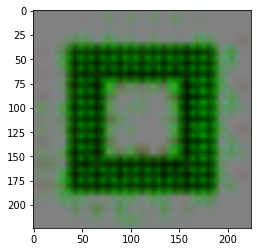

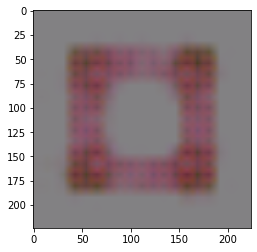

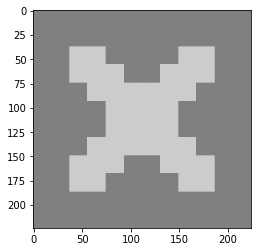

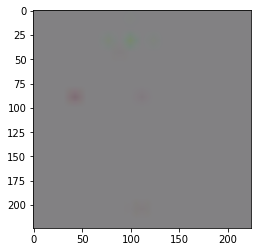

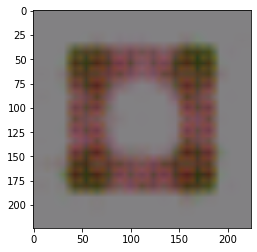

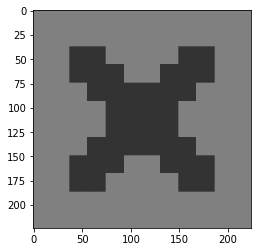

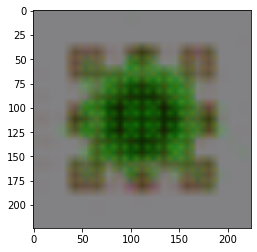

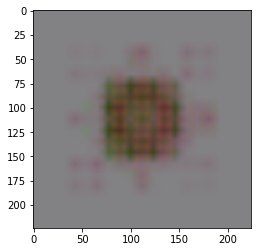

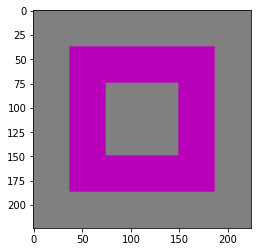

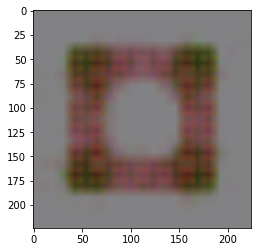

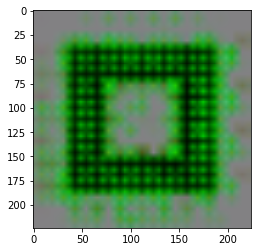

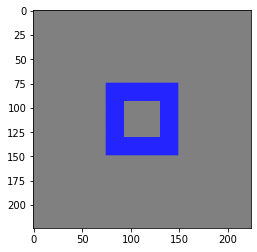

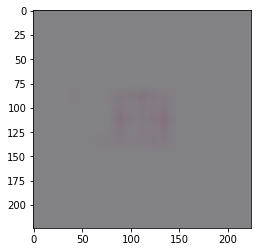

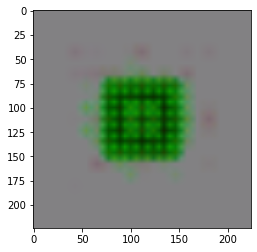

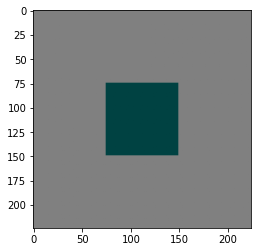

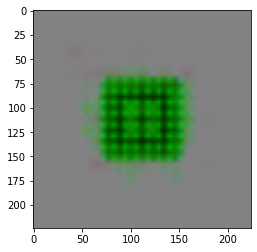

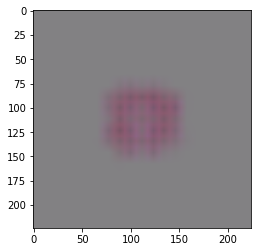

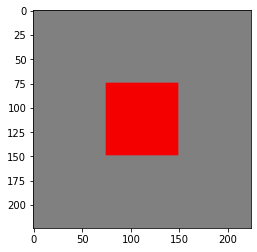

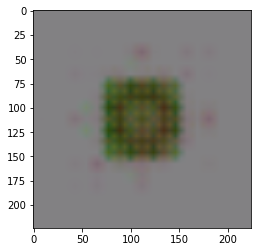

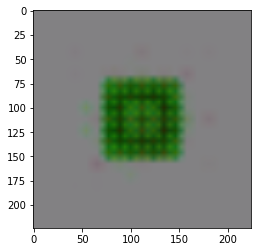

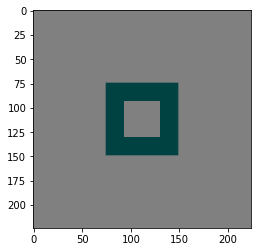

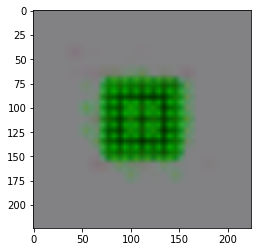

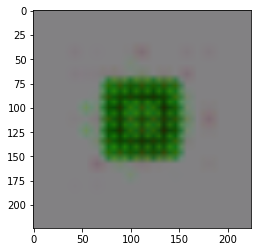

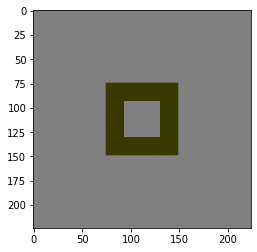

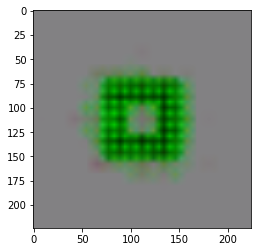

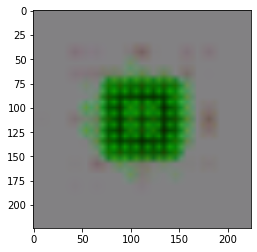

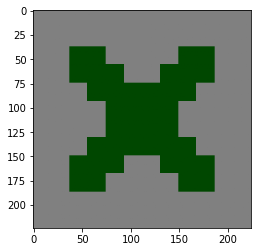

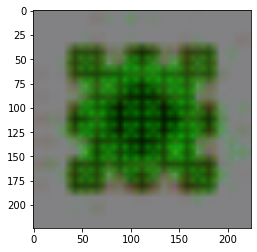

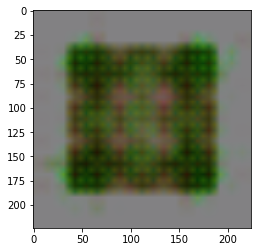

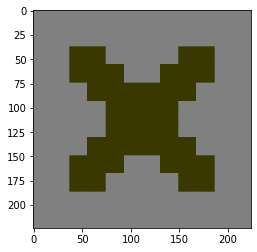

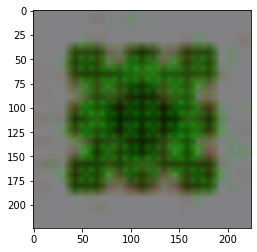

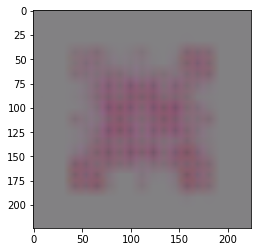

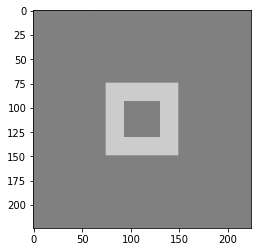

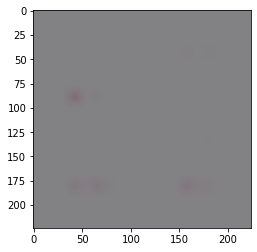

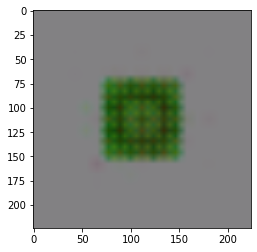

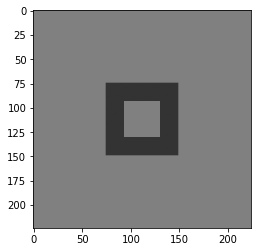

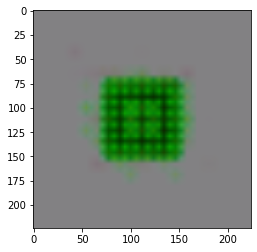

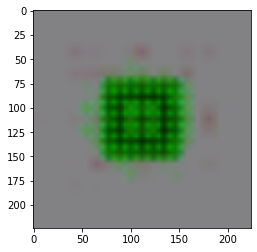

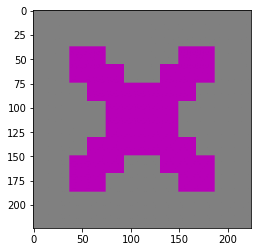

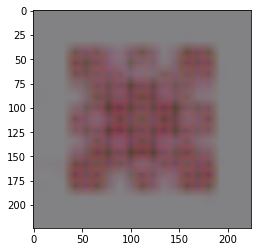

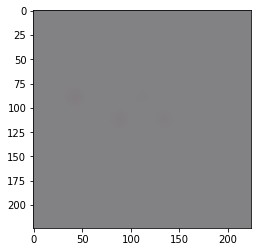

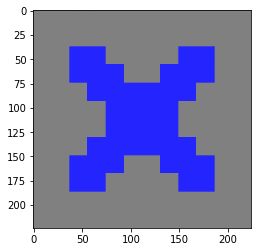

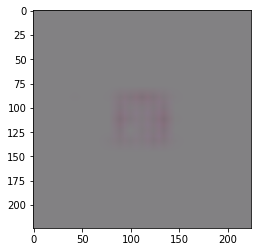

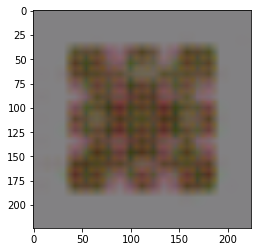

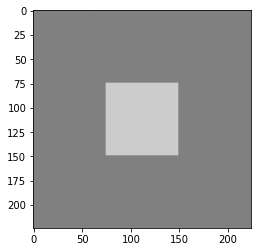

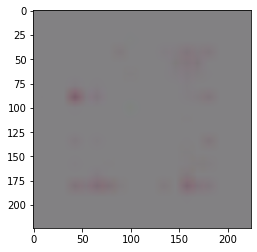

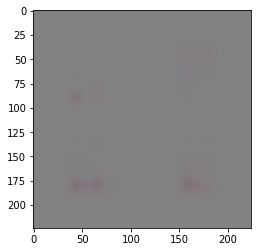

In [ ]:
img_encoder.eval()
img_decoder.eval()
mri_encoder.eval()

with torch.no_grad():
    tqdm_object = tqdm(testloader, total=len(testloader))
    for mris,images,labels in tqdm_object:
        mris,images = mris.to(device),images.to(device)
        mri_embeddings = mri_encoder(mris)
        embeddings = img_encoder(images)
        recon_imgs = img_decoder(embeddings)
        recon_imgs_mri = img_decoder(mri_embeddings)
        plt.imshow(images.squeeze().cpu().detach().squeeze().permute(1,2,0), interpolation='nearest')
        plt.show()
        plt.imshow(recon_imgs.cpu().detach().squeeze().permute(1,2,0), interpolation='nearest')
        plt.show()
        plt.imshow(recon_imgs_mri.squeeze().cpu().detach().permute(1,2,0), interpolation='nearest')
        plt.show()

    


In [ ]:
VNDSBV

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        ngf = 4
        nc=3
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( CFG.projection_dim, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nc),
            nn.ReLU(True),
            # state size. (nc) x 64 x 64
            nn.ConvTranspose2d( nc, nc, 4, 2, 1, bias=False),
            nn.BatchNorm2d(nc),
            nn.ReLU(True),
            # state size. (nc) x 128 x 128
            nn.ConvTranspose2d( nc, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 256 x 256
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet18,ResNet18_Weights
import torchvision.transforms as T


class Comparator(nn.Module):
    def __init__(self):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT
        self.encoder = resnet18(weights=weights)
        self.transforms = weights.transforms()

    def forward(self, x):
        self.features = []

        x = self.transforms(x)
        x = x.type(torch.DoubleTensor).to(device)

        x = self.encoder.conv1(x)
        x = self.encoder.bn1(x)
        x = self.encoder.relu(x)
        x = self.encoder.maxpool(x)
        self.features.append(x)

        x = self.encoder.layer1(x)
        self.features.append(x)

        x = self.encoder.layer2(x)
        self.features.append(x)

        x = self.encoder.layer3(x)
        self.features.append(x)

        x = self.encoder.layer4(x)
        self.features.append(x)

        x = self.encoder.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.encoder.fc(x)
        self.features.append(x)
        # we take the 3rd output feature map of 
        # size 8 x 8 from the resnet18 encoder, 256 channels
        return x

In [ ]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=1.0
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.mri_encoder = MriEncoder()
        self.temperature = temperature

    def forward(self, mris, images):
        # Getting Image and Text Features
        image_embeddings = self.image_encoder(images)
        mri_embeddings = self.mri_encoder(mris)
        print(image_embeddings)
        print(mri_embeddings)

        # Calculating the Loss
        logits = F.softmax((mri_embeddings @ image_embeddings.T) / self.temperature, dim=0)
        images_similarity = F.softmax(image_embeddings @ image_embeddings.T, dim=0)
        mris_similarity = F.softmax(mri_embeddings @ mri_embeddings.T, dim=0)
        # image_targets = F.softmax(
        #     (images_similarity + mris_similarity) / 2 * self.temperature, dim=-1
        # )
        print(logits)
        print(images_similarity)
        print(mris_similarity)
        criterion = nn.BCELoss()
        mris_loss = criterion(logits, mris_similarity)
        images_loss = criterion(logits, images_similarity)
        print(images_loss)
        print(mris_loss)
        loss =  (images_loss + mris_loss) / 2.0 
        return loss


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [ ]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for mris,images,labels in tqdm_object:
        mris,images = mris.to(device),images.to(device)
        loss = model(mris,images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = images.size(0)
        loss_meter.update(loss.item(), count)
        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter

In [ ]:
def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for mris,images,labels in tqdm_object:
        mris,images = mris.to(device),images.to(device)
        loss = model(mris,images)

        count = images.size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter

In [ ]:
model = CLIPModel().to(device)
params = [
    {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
    {"params": model.mri_encoder.parameters(), "lr": CFG.text_encoder_lr},
]
optimizer = torch.optim.AdamW(params, weight_decay=CFG.weight_decay)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
)
step = "epoch"

best_loss = float('inf')
for epoch in range(CFG.epochs):
    print(f"Epoch: {epoch + 1}")
    model.train()
    train_loss = train_epoch(model, trainloader, optimizer, lr_scheduler, step)
    model.eval()
    with torch.no_grad():
        valid_loss = valid_epoch(model, testloader)
    
    if valid_loss.avg < best_loss:
        best_loss = valid_loss.avg
        torch.save(model.state_dict(), "best-shapes.pt")
        print("Saved Best Model!")
    
    lr_scheduler.step(valid_loss.avg)

In [ ]:
def get_image_embeddings(testloader, model_path):
    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()
    
    valid_image_embeddings = []
    image_labels = []
    with torch.no_grad():
        for mris,images,labels in tqdm(testloader):
            if labels not in image_labels:
              image_embeddings = model.image_encoder(images.to(CFG.device))
              valid_image_embeddings.append(image_embeddings)
              image_labels.append(labels)
    return model, torch.cat(valid_image_embeddings),image_labels

In [ ]:
def find_matches(model, image_embeddings, mri, image_filenames,n=9):
    
    
    with torch.no_grad():
        mri_embeddings = model.mri_encoder(mri)
    
    # image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    # mri_embeddings_n = F.normalize(mri_embeddings, p=2, dim=-1)
    dot_similarity = mri_embeddings @ image_embeddings.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), n)
    # print(values)
    # print(indices)

    matches = [image_filenames[idx] for idx in indices[:n]]
    
    return matches

In [ ]:
final_test_h5_paths = [
                  'data/fmri/sub-01_perceptionNaturalImageTest_original_VC.h5',
                 
                # 'data/fmri/sub-02_perceptionNaturalImageTest_original_VC.h5',
                  
                  # 'data/fmri/sub-03_perceptionNaturalImageTraining_original_VC.h5',
                 ]

lmdb_test = "lmdb_test"

In [ ]:
final_test_dataset = ImageReconstructionDataset(X_paths= final_test_h5_paths, y_path= lmdb_test)

finaltestloader = torch.utils.data.DataLoader(
    final_test_dataset, batch_size=1, num_workers=0, shuffle=True)

In [ ]:
import matplotlib.pyplot as plt
model_path = "best-tanh.pt"
model,image_embeddings,image_labels = get_image_embeddings(finaltestloader, model_path)


In [ ]:
len(image_labels)

In [ ]:
count = {}
accuracy = 0
for mri, image, label in tqdm(finaltestloader):
    mri,image = mri.to(device), image.to(device)
    matched_images = find_matches(model, image_embeddings, mri, image_labels, n=5)
    label1 = matched_images[0][0]
    count[label1] = count.get(label1,0) + 1
    if label in matched_images:
      accuracy = accuracy + 1
      

    
  

    
print(accuracy)                
print(count)


In [ ]:
for batch_idx, (mri, image, label) in enumerate(finaltestloader):
  print(image.shape)
  break


In [ ]:
len(count.keys())

In [ ]:
x = torch.arange(1., 100.)


In [ ]:
1 in (1,2)

In [ ]:
env = lmdb.open(lmdb_test)
with env.begin(write=True) as txn:
      image = (pickle.loads(txn.get('n02814860_39856'.encode("ascii"))).get_image())
      image = torch.from_numpy(image)
      plt.imshow(image.squeeze(), interpolation='nearest')
      plt.show()
env.close()


In [ ]:
4261/6000

In [ ]:
model.image_encoder

In [ ]:
torch.tensor([1,2,3]).shape[0]